# Introdução

Neste caderno, usei a **CNN** para realizar a classificação de imagens no conjunto de dados de tumores cerebrais.<br>
Como esse conjunto de dados é pequeno, se treinarmos uma rede neural para ele, não teremos um bom resultado.<br>
Portanto, usarei o conceito de **Aprendizado por transferência** para treinar o modelo e obter resultados realmente precisos.

Neste Link é possível acessar o banco de dados utilizado neste estudo 

https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri?rvi=1

O modelo utilizado para o **Aprendizado por transferêrencia** foi o **EfficientNetB0** a documentação do mesmo segue a baixo.

https://keras.io/api/applications/efficientnet/

<img src="https://c0.klipartz.com/pngpicture/876/331/gratis-png-circuito-electronico-circuito-integrado-circuitos-integrados-y-chips-placa-de-circuito-impreso-cerebro.png" alt="Brain" style="width: 700px;">

### Note

Se você achar este caderno útil e intuitivo, sinta-se à vontade para votá-lo positivamente! Dê-me suas sugestões ou opiniões para que eu possa melhorar meu trabalho! Eu apreciarei muito isso! Obrigado! :)

---

# Importando bibliotecas

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings


---

# Color

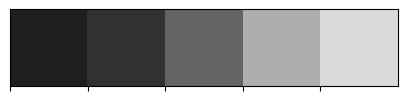

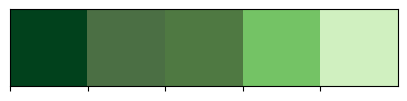

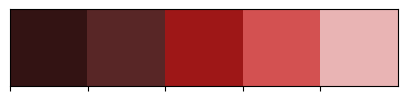

In [23]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

---

# Data Preperation

In [24]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

Começamos anexando todas as imagens dos diretórios em uma lista Python e depois convertendo-as em arrays numpy após redimensioná-las.

In [25]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('Brain tumor dataset','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('Brain tumor dataset','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 241.72it/s]


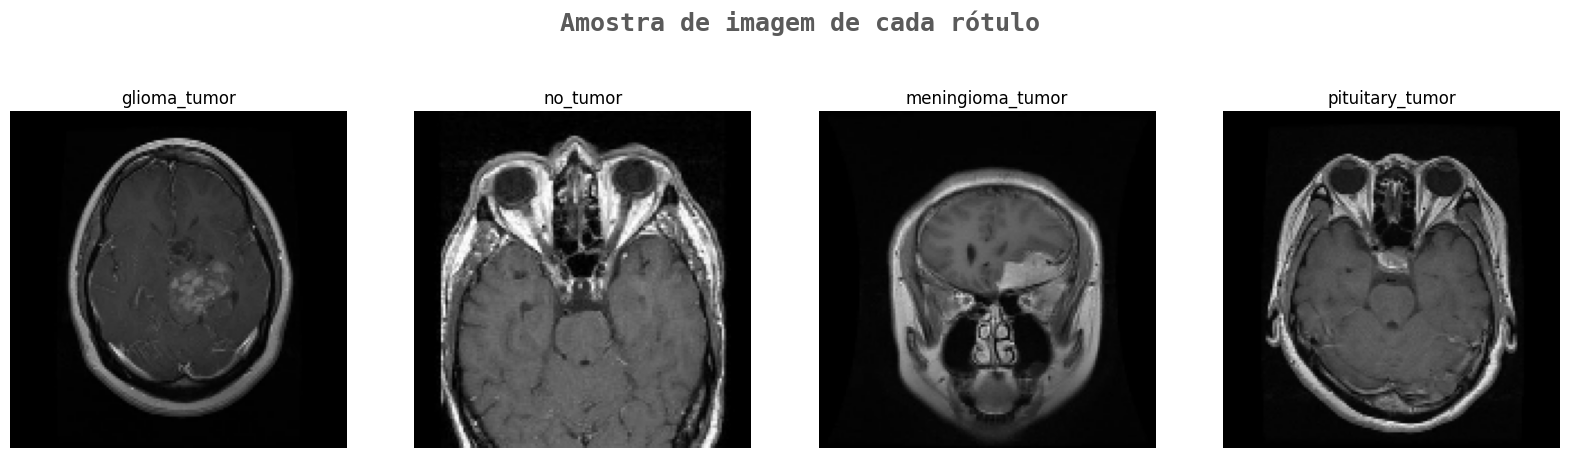

In [26]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Amostra de imagem de cada rótulo',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [27]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [28]:
X_train.shape

(3264, 150, 150, 3)

Dividindo o dataset em **Training** e **Testing** sets.

In [29]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

Executando **One Hot Encoding** nas etiquetas após convertê-las em valores numéricos:

In [30]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

---

# Transfer Learning

Deep convolutional neural network models podem levar dias ou semanas para serem treinadas em conjuntos de dados extensos.

Uma maneira de abreviar esse processo é reutilizar os pesos dos modelos pré-treinados que foram desenvolvidos para conjuntos de dados de benchmark de visão computacional padrão, como as tarefas de reconhecimento de imagem ImageNet. Os modelos de melhor desempenho podem ser baixados e usados diretamente ou integrados em um novo modelo para seus próprios problemas de visão computacional.

Neste notebook, usarei o modelo **EfficientNetB0** que usará os pesos do conjunto de dados **ImageNet**.

O parâmetro include_top é definido como *False* para que a rede não inclua a camada superior/camada de saída do modelo pré-construído, o que nos permite adicionar nossa própria camada de saída dependendo do nosso caso de uso!

In [31]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

**GlobalAveragePooling2D** -> Esta camada atua de forma semelhante à camada Max Pooling em CNNs, a única diferença é que ela usa os valores médios em vez do valor máximo durante o *pooling*. Isso realmente ajuda a diminuir a carga computacional da máquina durante o treinamento.
<br><br>
**Dropout** -> Esta camada omite alguns dos neurônios em cada etapa da camada, tornando os neurônios mais independentes dos neurônios vizinhos. Ajuda a evitar overfitting. Os neurônios a serem omitidos são selecionados aleatoriamente. O parâmetro **taxa** é a probabilidade de uma ativação de neurônio ser definida como 0, eliminando assim o neurônio

**Dense** -> Esta é a camada de saída que classifica a imagem em 1 das 4 classes possíveis. Ele usa a função **softmax** que é uma generalização da função sigmóide.

In [32]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [33]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 150, 150, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 150, 150, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 150, 150, 3)          0         ['normalization_1[0][0]'

Por fim nós compilamos nosso modelo

In [34]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

**Retornos de chamada** -> Os retornos de chamada podem ajudá-lo a corrigir bugs mais rapidamente e a criar modelos melhores. Eles podem ajudar você a visualizar como está o treinamento do seu modelo e até mesmo ajudar a evitar overfitting implementando a parada antecipada ou personalizando a taxa de aprendizado em cada iteração.<br><br>
Por definição, "Um retorno de chamada é um conjunto de funções a serem aplicadas em determinados estágios do procedimento de treinamento. Você pode usar retornos de chamada para obter uma visão dos estados internos e das estatísticas do modelo durante o treinamento."

Neste notebook, usarei as funções de retorno de chamada **TensorBoard, ModelCheckpoint e ReduceLROnPlateau**

In [35]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

---

# Training The Model

**Nota**: O treinamento leva muito tempo! ~ 30 minutos para mim (usando CPU)<be>
Mal demorou 5 minutos com a GPU.

In [36]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,)
                   #callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 [==============================] - 127s 1s/step - loss: 0.4145 - accuracy: 0.8422 - val_loss: 0.3013 - val_accuracy: 0.9048
Epoch 2/12
83/83 [==============================] - 107s 1s/step - loss: 0.1769 - accuracy: 0.9357 - val_loss: 0.2016 - val_accuracy: 0.9456
Epoch 3/12
83/83 [==============================] - 102s 1s/step - loss: 0.1371 - accuracy: 0.9557 - val_loss: 0.2516 - val_accuracy: 0.9218
Epoch 4/12
83/83 [==============================] - 90s 1s/step - loss: 0.0925 - accuracy: 0.9690 - val_loss: 0.2280 - val_accuracy: 0.9388
Epoch 5/12
83/83 [==============================] - 156s 2s/step - loss: 0.1014 - accuracy: 0.9641 - val_loss: 0.5729 - val_accuracy: 0.8027
Epoch 6/12
83/83 [==============================] - 204s 2s/step - loss: 0.0860 - accuracy: 0.9735 - val_loss: 0.1667 - val_accuracy: 0.9592
Epoch 7/12
83/83 [==============================] - 174s 2s/step - loss: 0.0416 - accuracy: 0.9871 - val_loss: 0.2352 - val_accuracy: 0.9626
Epoch 8/12
83/

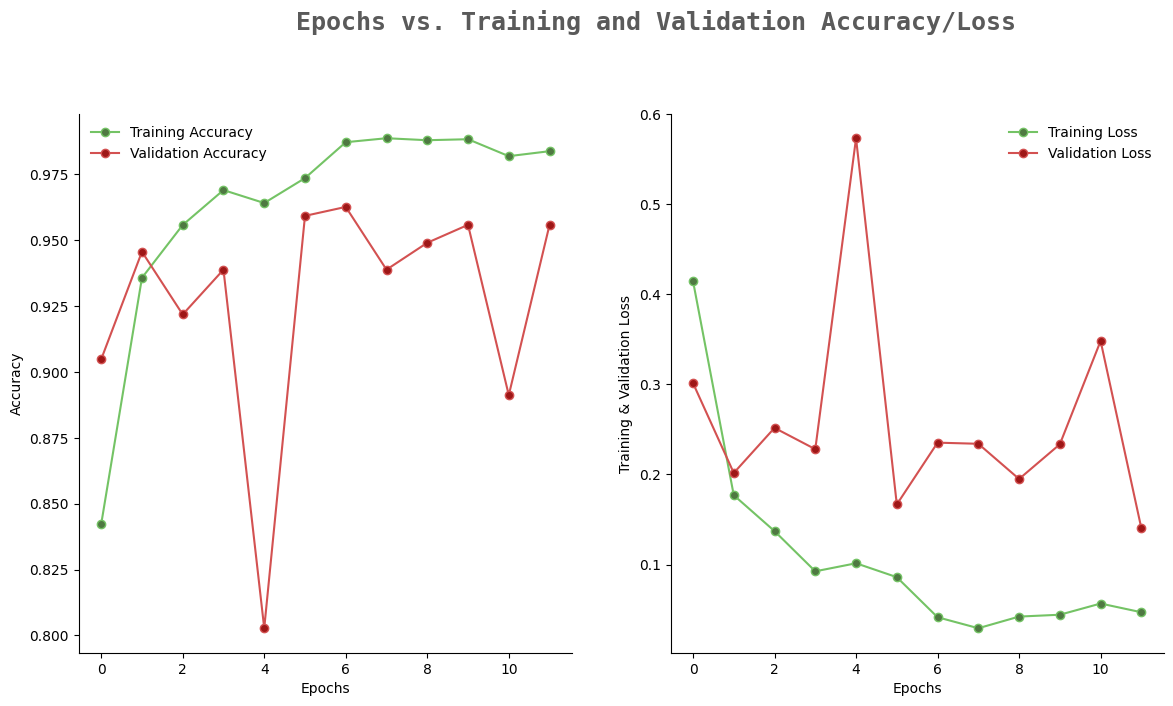

In [37]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

---

# Prediction

Usei a *função argmax* pois cada linha da matriz de previsão contém quatro valores para os respectivos rótulos. O valor **máximo** que está em cada linha representa o resultado previsto dos quatro resultados possíveis.<br>
Assim, com *argmax*, consigo descobrir o índice associado ao resultado previsto.

In [38]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 10s 490ms/step


---

# Avaliação

Então, <br>
0 - Glioma Tumor<br>
1 - No Tumor<br>
2 - Meningioma Tumor<br>
3 - Pituitary Tumor<br>

In [39]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94        93
           1       0.88      1.00      0.94        51
           2       0.93      0.96      0.94        96
           3       1.00      0.95      0.98        87

    accuracy                           0.95       327
   macro avg       0.95      0.96      0.95       327
weighted avg       0.95      0.95      0.95       327



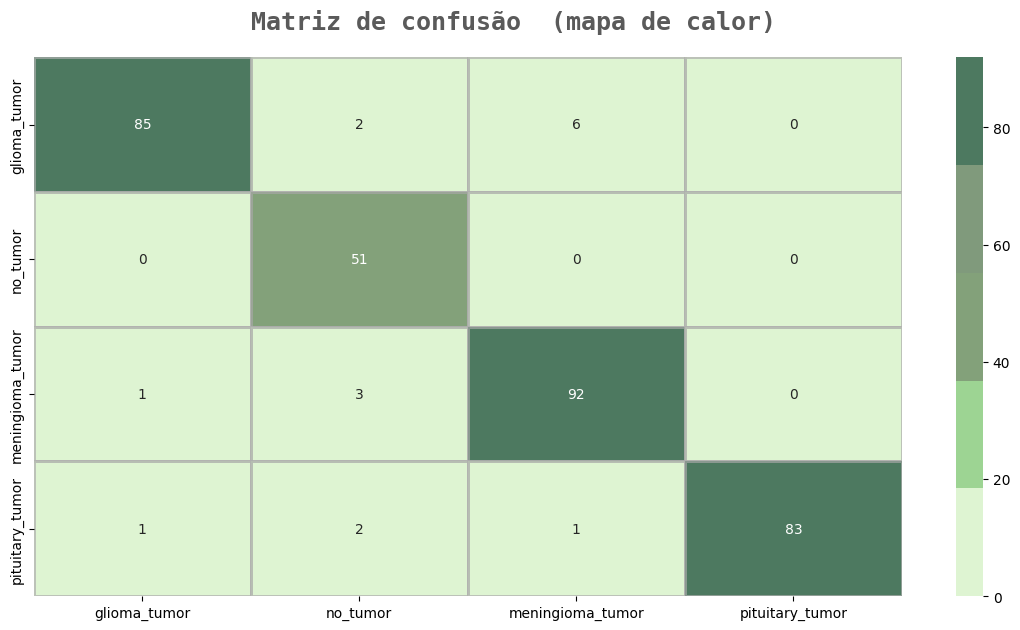

In [40]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Matriz de confusão  (mapa de calor)',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

---

In [41]:
import cv2
import numpy as np
from PIL import Image
import os

# Caminho para a imagem
img_path = os.path.join('Brain tumor dataset', 'Testing', 'glioma_tumor', 'image.jpg')

# Carregar a imagem usando PIL
img_pil = Image.open(img_path)

# Converter a imagem PIL para uma matriz numpy
opencvImage = np.array(img_pil)

# Converter a imagem de RGB para BGR
opencvImage = cv2.cvtColor(opencvImage, cv2.COLOR_RGB2BGR)

# Redimensionar a imagem
img_resized = cv2.resize(opencvImage, (150, 150))

# Adicionar uma dimensão extra para representar o lote (batch)
img_resized = img_resized.reshape(1, 150, 150, 3)

# Agora você pode prosseguir com a previsão usando seu modelo
p = model.predict(img_resized)
p = np.argmax(p, axis=1)[0]
print(p)


1/1 [==============================] - 0s 210ms/step
0


In [42]:
if p==0:
    p='Glioma Tumor'
elif p==1:
    print('The model predicts that there is no tumor')
elif p==2:
    p='Meningioma Tumor'
else:
    p='Pituitary Tumor'
if p!=1:
        print(f'The Model predicts that it is a {p}')

The Model predicts that it is a Glioma Tumor


---

# Conclusão

Neste notebook, realizei Classificação de Imagens com auxílio da CNN utilizando Transfer Learning que deu uma precisão em torno de 98%.<br>
Também criei widgets que podem fazer previsões sobre uma imagem da sua máquina local!

---

# <center>Thank You!